# Spectrogram

This code has a nice time axis and can help to gain first insights in the frequency distribution.

In [1]:
import numpy as np
import pandas as pd
import obspy
import obspy.signal.filter
from obspy import UTCDateTime
import sys
sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()
import datetime
import scipy
import glob
import os
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib

sys.path.append('/home/koepflma/project1/Mt-St-Helens')
from functions import *

In [2]:
# read data to stream
net = 'UW'
sta = 'EDM'
cha = 'EHZ'
year = 2004
jday = 268
try:
    st_r = read_stream(net, sta, cha, year, jday)
except:
    print('Problem during reading mseed to stream: {}-{}'.format(year,day))
st_r

5 Trace(s) in Stream:
UW.EDM..EHZ | 2004-09-24T00:00:00.000000Z - 2004-09-24T00:40:20.060000Z | 100.0 Hz, 242007 samples
UW.EDM..EHZ | 2004-09-24T00:40:20.081000Z - 2004-09-24T01:39:10.071000Z | 100.0 Hz, 353000 samples
UW.EDM..EHZ | 2004-09-24T01:39:10.091000Z - 2004-09-24T02:38:10.081000Z | 100.0 Hz, 354000 samples
UW.EDM..EHZ | 2004-09-24T02:38:10.100900Z - 2004-09-24T15:50:15.230900Z | 100.0 Hz, 4752514 samples
UW.EDM..EHZ | 2004-09-24T15:50:33.251300Z - 2004-09-24T23:59:59.991300Z | 100.0 Hz, 2936675 samples

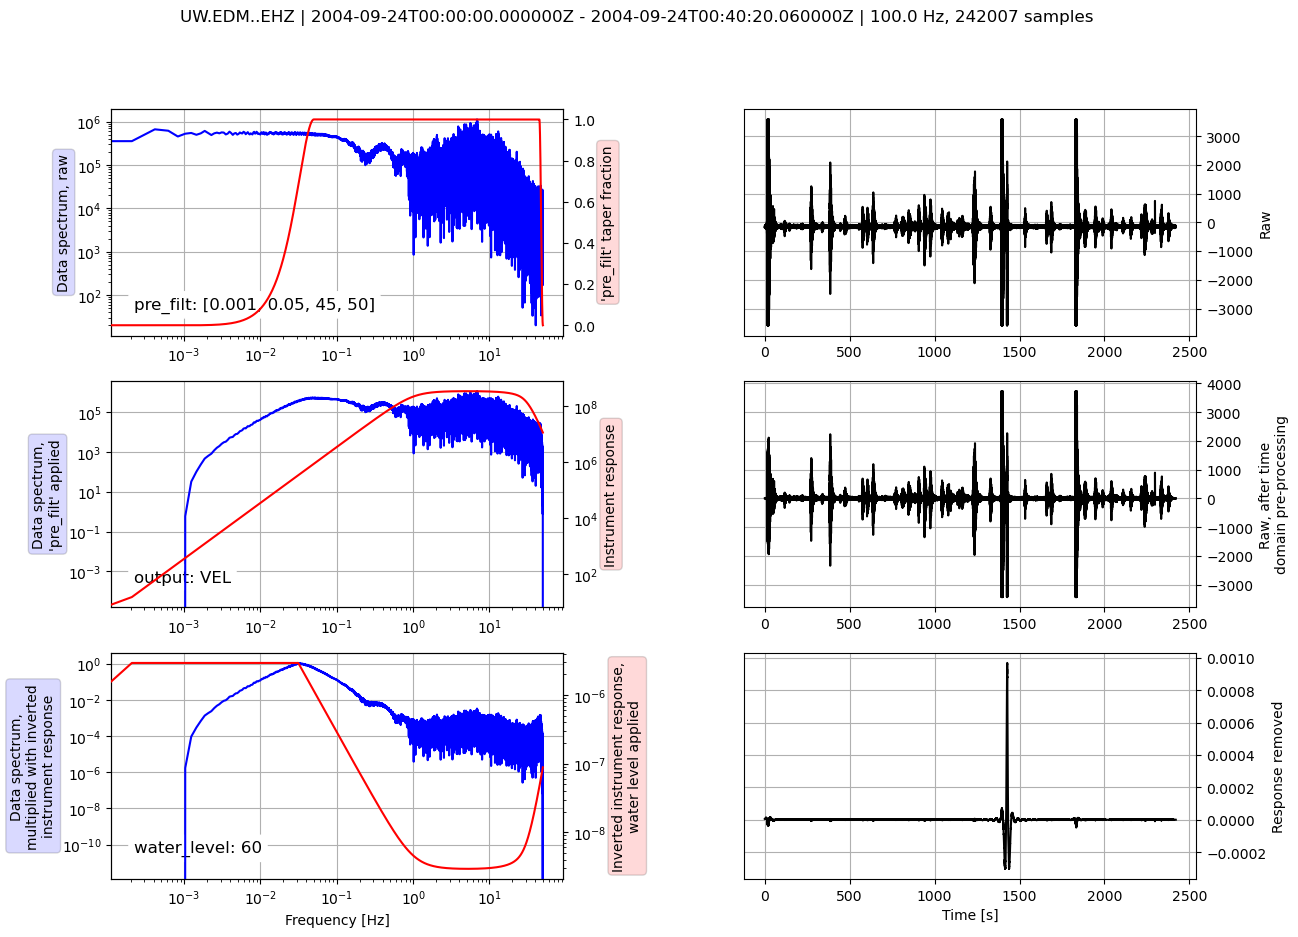

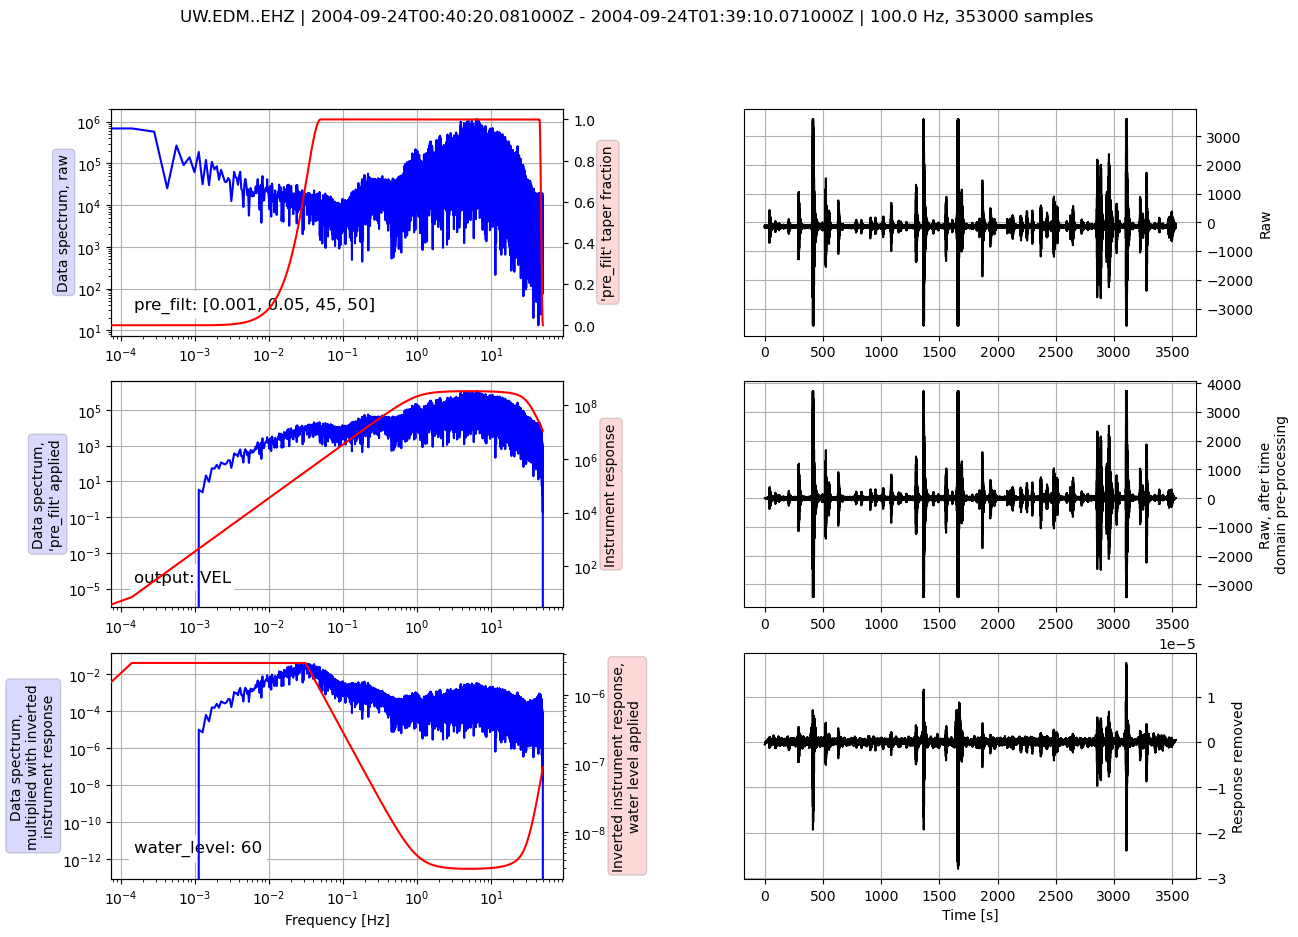

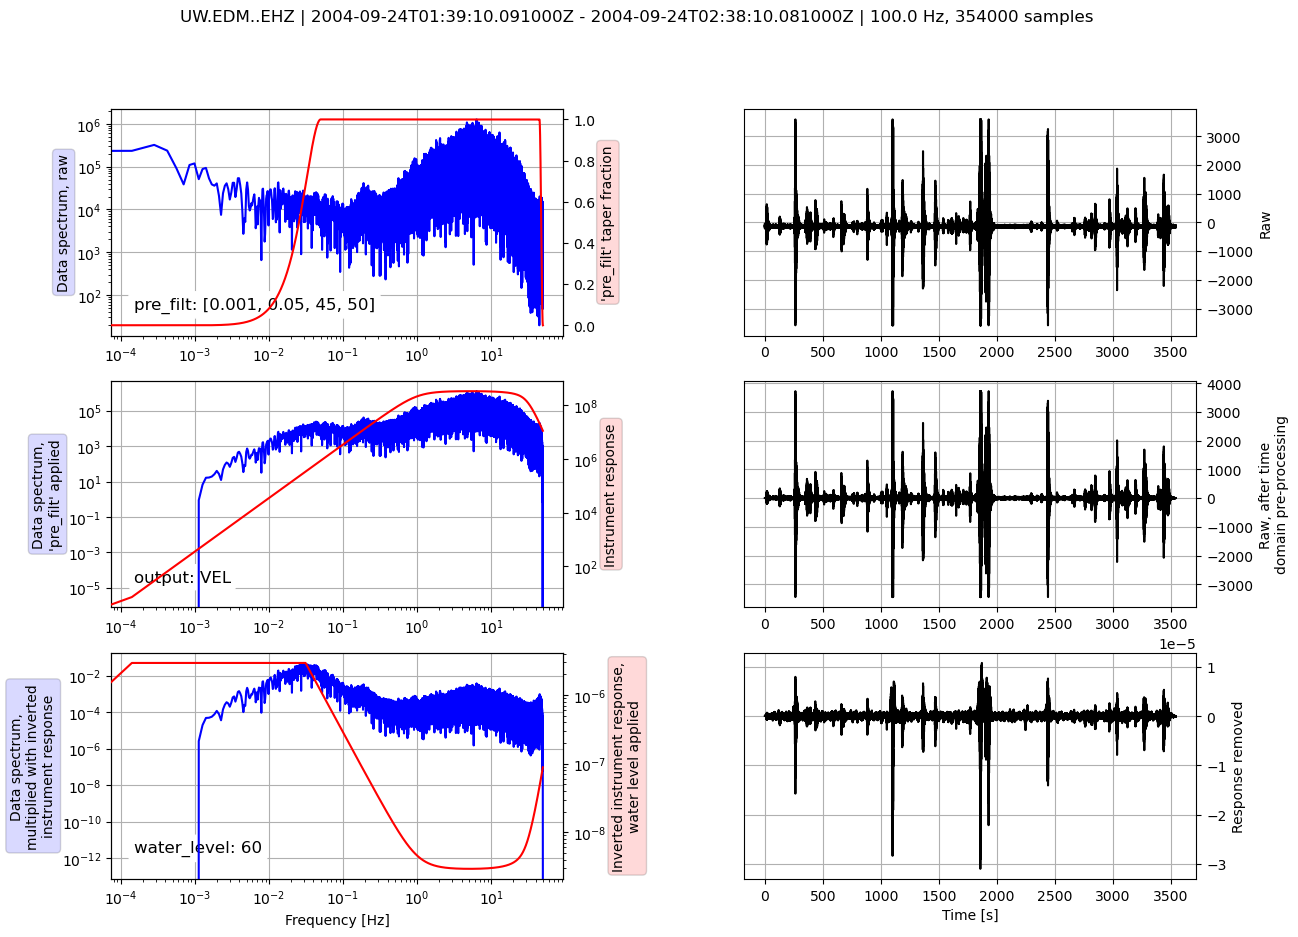

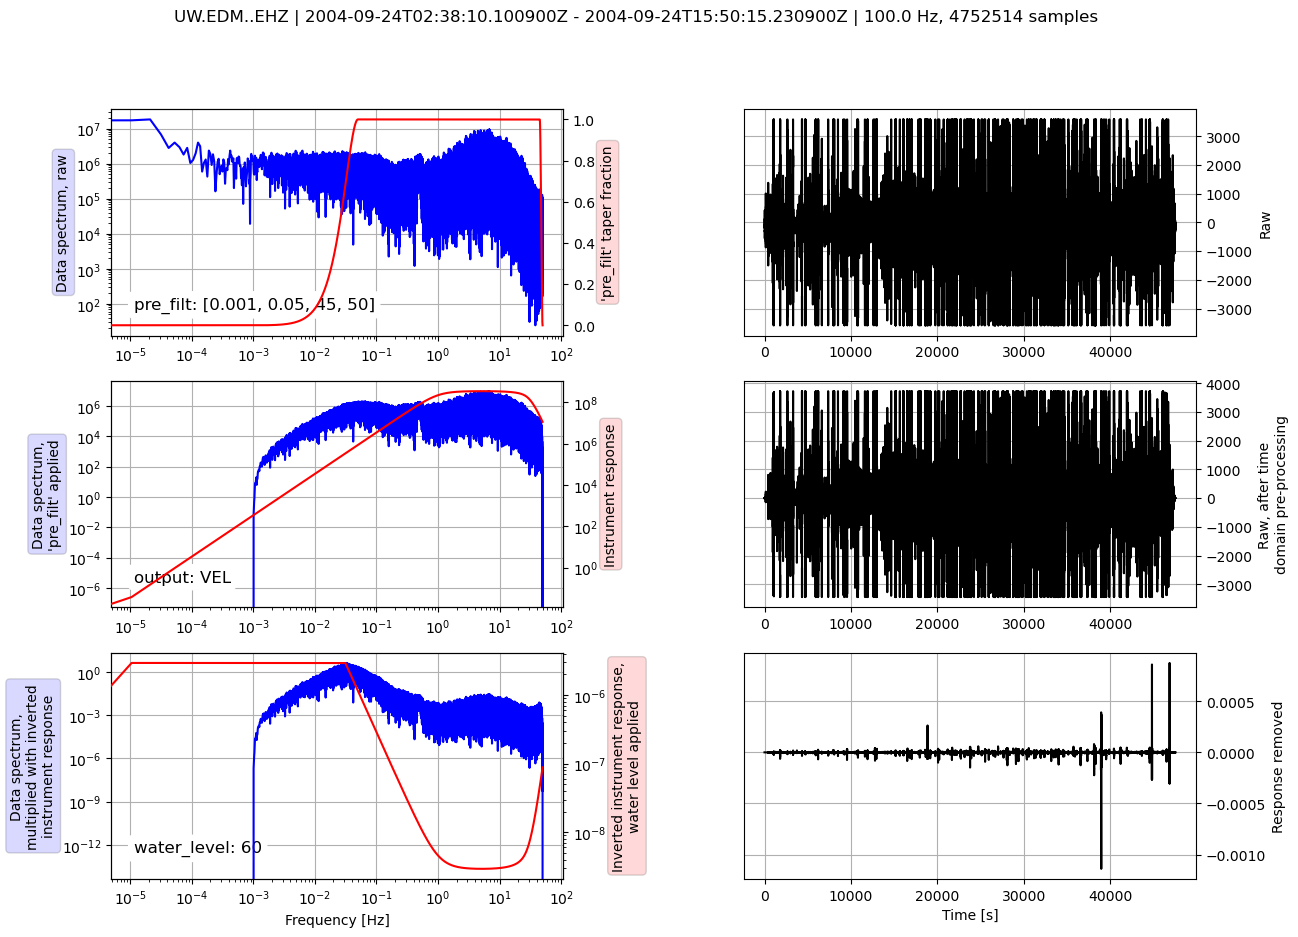

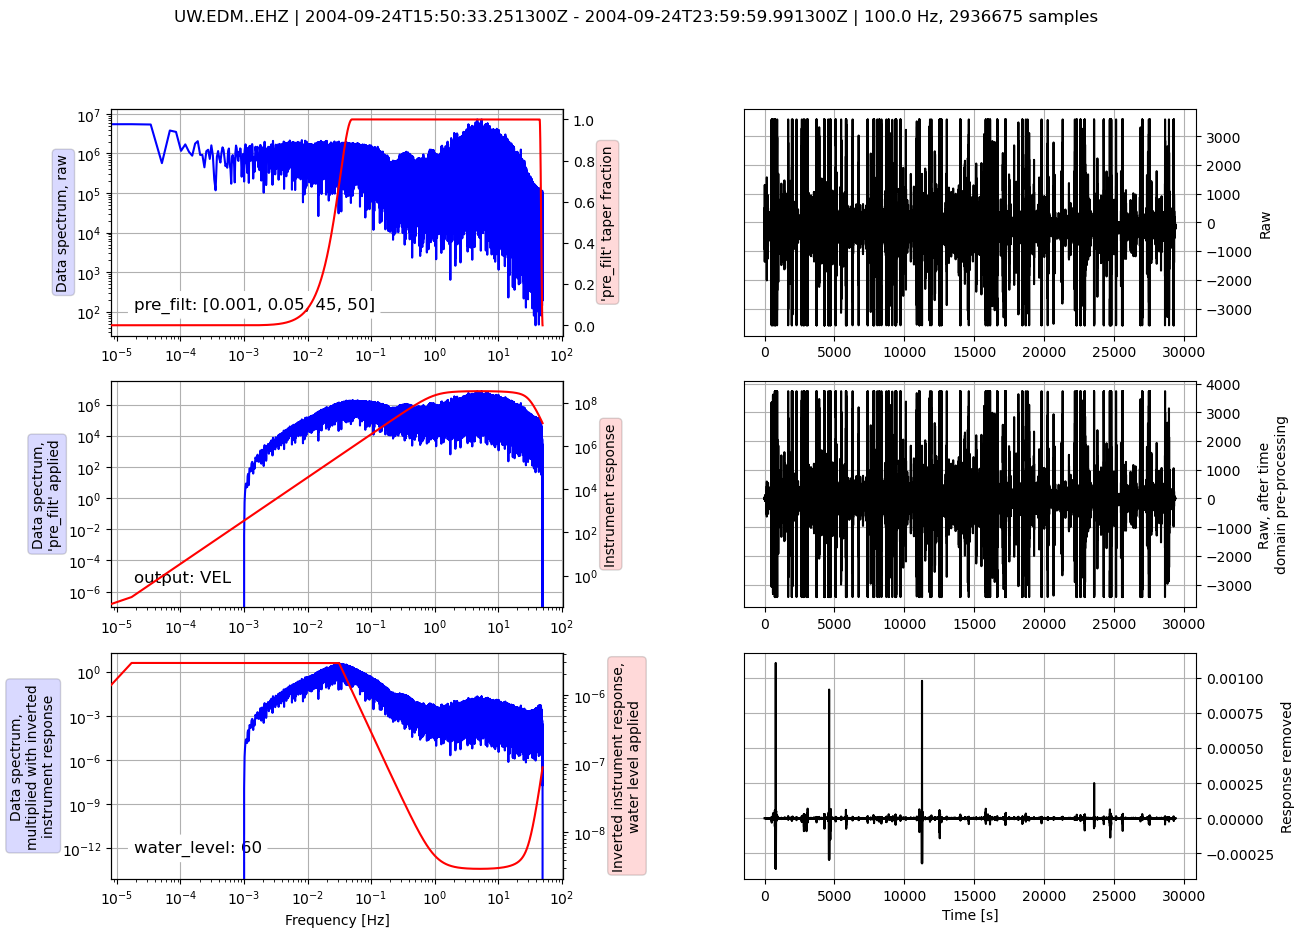

In [3]:
# correct insrument response
inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
pre_filt = [1e-3, 5e-2, 45, 50]
water_level = 60
st_corr = st_r.copy()
for tr in st_corr:
    s_time_str = str(tr.stats['starttime']).split('.')[0].replace(':', '-')
    tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                          pre_filt=pre_filt, output="VEL", water_level=water_level,
                          plot=True)
#                           plot='sensor_response_tests/{}__pre_filt{}-{}_{}-{}__water_level{}.png'.format(
#                           s_time_str,
#                           pre_filt[0], pre_filt[1], pre_filt[2], pre_filt[3], water_level))

In [118]:
# without trimming but with instrument correction
st = st_corr.copy()
st.merge()

1 Trace(s) in Stream:
UW.EDM..EHZ | 2004-09-23T00:00:00.006700Z - 2004-09-23T11:59:59.996700Z | 100.0 Hz, 4320000 samples (masked)

In [272]:
# with trimming
stime = UTCDateTime('2004-09-23T06:00:00')
etime = UTCDateTime('2004-09-23T12:00:00')

st = st_corr.copy()
st.trim(stime, etime)  
st.merge()

1 Trace(s) in Stream:
UW.EDM..EHZ | 2004-09-23T05:59:59.996700Z - 2004-09-23T11:59:59.996700Z | 100.0 Hz, 2160001 samples (masked)

In [47]:
# without trimming and without instrument correction
st = st_r.copy()
st.merge()

1 Trace(s) in Stream:
UW.HSR..EHZ | 2004-09-23T00:00:00.002800Z - 2004-09-23T23:59:59.992800Z | 100.0 Hz, 8640000 samples (masked)

In [133]:
# width trimming and without instument correction
stime = UTCDateTime('2004-09-23T00:00:00')
etime = UTCDateTime('2004-09-23T12:00:00')

st = st_r.copy()
st.trim(stime, etime)  
st.merge()

1 Trace(s) in Stream:
UW.EDM..EHZ | 2004-09-23T00:00:00.006700Z - 2004-09-23T11:59:59.996700Z | 100.0 Hz, 4320000 samples (masked)

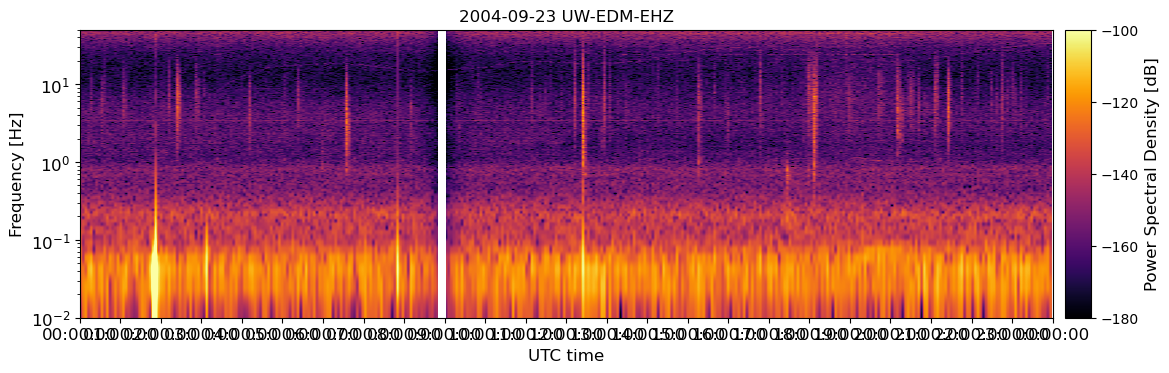

In [257]:
tr = st[0] # only get one obspy trace from obspy stream
data = tr.data # extract numpy data array from obspy trace
fs = tr.stats.sampling_rate #sampling rate

NFFT = fs * 60 # bin size for fourier transform. Type in length (seconds)

fig = plt.figure(figsize=(6.4*2,4.8)) #create figure and add axes to it
# ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.60]) #[left bottom width height]
# ax2 = fig.add_axes([0.83, 0.1, 0.03, 0.6])
ax1 = fig.add_axes([0.125, 0.125, 0.76, 0.6])
ax2 = fig.add_axes([0.895, 0.125, 0.02, 0.6]) # colorbar

#plot spectrogram on first axis
Pxx, freqs, bins, im = ax1.specgram(data, NFFT=int(NFFT), Fs=fs,
                                    noverlap=60,         # overlap of bins in samples
                                    detrend='linear',   # detrending before taking fourier transform
                                    mode='psd',         # 'psd', 'magnitude', 'angle', 'phase'
                                    scale_by_freq=True, # unit/Hz
                                    scale='dB',         #'linear', 'dB'
                                    cmap='inferno',     # your favourite colormap
                                    vmin=-180,
                                    vmax=-100,
                                   )


# show hour of day on x-axis
h_int = 1
x_ticks = pd.date_range(st[0].stats.starttime.datetime, st[0].stats.starttime.datetime+datetime.timedelta(days=1)
                        , freq=str(h_int)+'H', normalize=True)
x_tickloc = [UTCDateTime(t).timestamp for t in x_ticks]
x_tickloc = np.linspace(np.min(bins), np.max(bins), len(x_ticks))
ax1.set_title('{} {}-{}-{}'.format(stime.date,net,sta,cha))
ax1.set_xticks(x_tickloc)
ax1.set_xticklabels(['{}'.format(x.time()) for x in x_ticks])
ax1.set_xlim(bins[0], bins[-1])

ax1.set_xlabel('UTC time', fontsize=12) #x-label


ax1.set_ylabel('Frequency [Hz]', fontsize=12) #y-label
ax1.tick_params(axis='both', labelsize=12)

ax1.set_yscale('log')
ax1.set_ylim([0.01,50]) #be carefull with lower limit when y-scale is logarithmic
# ax1.set_ylim([1,10]) #be carefull with lower limit when y-scale is logarithmic

cbar = plt.colorbar(im, cax=ax2) #map colorbar to image (output of specgram), plot it on ax2
cbar.set_label('Power Spectral Density [dB]', fontsize=12) #colorbar label
cbar.ax.locator_params(nbins=5)

# fig.savefig('spectrogram/eq_swarm/{}_{}_{}_log.png'.format(year,stime,sta), dpi=300, bbox_inches='tight')
plt.show()

In [269]:
x_ticks = pd.date_range(st[0].stats.starttime.datetime, st[0].stats.endtime.datetime+datetime.timedelta(days=1)
                        , freq=str(h_int)+'H', normalize=True)
x_ticks

DatetimeIndex(['2004-09-23 00:00:00', '2004-09-23 01:00:00',
               '2004-09-23 02:00:00', '2004-09-23 03:00:00',
               '2004-09-23 04:00:00', '2004-09-23 05:00:00',
               '2004-09-23 06:00:00', '2004-09-23 07:00:00',
               '2004-09-23 08:00:00', '2004-09-23 09:00:00',
               '2004-09-23 10:00:00', '2004-09-23 11:00:00',
               '2004-09-23 12:00:00', '2004-09-23 13:00:00',
               '2004-09-23 14:00:00', '2004-09-23 15:00:00',
               '2004-09-23 16:00:00', '2004-09-23 17:00:00',
               '2004-09-23 18:00:00', '2004-09-23 19:00:00',
               '2004-09-23 20:00:00', '2004-09-23 21:00:00',
               '2004-09-23 22:00:00', '2004-09-23 23:00:00',
               '2004-09-24 00:00:00'],
              dtype='datetime64[ns]', freq='H')

In [271]:
st[0].stats.endtime.datetime+datetime.timedelta(days=1)

datetime.datetime(2004, 9, 24, 11, 59, 59, 996700)

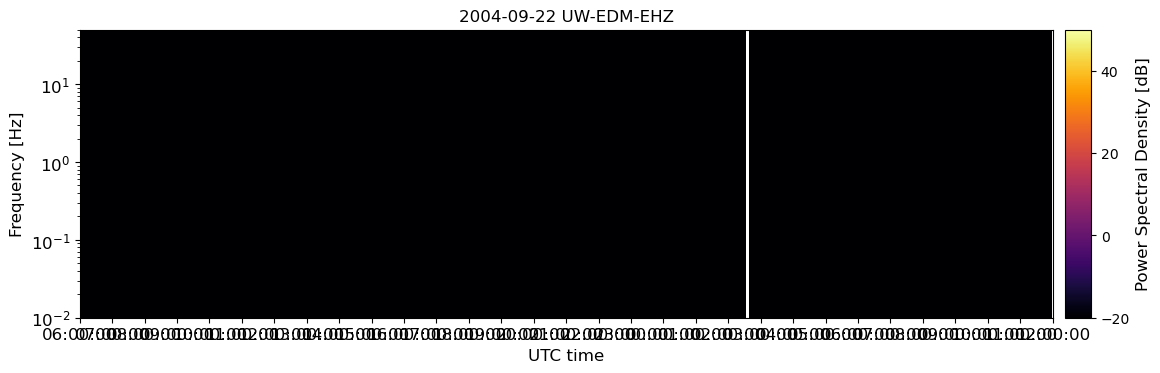

In [248]:
tr = st[0] # only get one obspy trace from obspy stream
data = tr.data # extract numpy data array from obspy trace
fs = tr.stats.sampling_rate #sampling rate

NFFT = fs * 60 # bin size for fourier transform. Type in length (seconds)

fig = plt.figure(figsize=(6.4*2,4.8)) #create figure and add axes to it
# ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.60]) #[left bottom width height]
# ax2 = fig.add_axes([0.83, 0.1, 0.03, 0.6])
ax1 = fig.add_axes([0.125, 0.125, 0.76, 0.6])
ax2 = fig.add_axes([0.895, 0.125, 0.02, 0.6]) # colorbar

#plot spectrogram on first axis
Pxx, freqs, bins, im = ax1.specgram(data, NFFT=int(NFFT), Fs=fs,
                                    noverlap=60,         # overlap of bins in samples
                                    detrend='linear',   # detrending before taking fourier transform
                                    mode='psd',         # 'psd', 'magnitude', 'angle', 'phase'
                                    scale_by_freq=True, # unit/Hz
                                    scale='dB',         #'linear', 'dB'
                                    cmap='inferno',     # your favourite colormap
                                    vmin=-20,
                                    vmax=50,
                                   )


# show hour of day on x-axis
h_int = 1

# x_ticks = np.arange(0,24+h_int,h_int)
x_ticks = pd.date_range(stime.datetime, etime.datetime, freq=str(h_int)+'H')
x_tickloc = np.linspace(np.min(bins), np.max(bins), len(x_ticks))
ax1.set_title('{} {}-{}-{}'.format(stime.date,net,sta,cha))
ax1.set_xticks(x_tickloc)
ax1.set_xticklabels(['{}'.format(x.time()) for x in x_ticks])
ax1.set_xlim(np.min(bins), np.max(bins))

ax1.set_xlabel('UTC time', fontsize=12) #x-label


ax1.set_ylabel('Frequency [Hz]', fontsize=12) #y-label
ax1.tick_params(axis='both', labelsize=12)

ax1.set_yscale('log')
ax1.set_ylim([0.01,50]) #be carefull with lower limit when y-scale is logarithmic
# ax1.set_ylim([1,10]) #be carefull with lower limit when y-scale is logarithmic

cbar = plt.colorbar(im, cax=ax2) #map colorbar to image (output of specgram), plot it on ax2
cbar.set_label('Power Spectral Density [dB]', fontsize=12) #colorbar label
cbar.ax.locator_params(nbins=5)

# fig.savefig('spectrogram/eq_swarm/{}_{}_{}_log.png'.format(year,jday,sta), dpi=300, bbox_inches='tight')
plt.show()

In [239]:
tr.stats.starttime

2004-09-22T18:00:00.000200Z

In [240]:
x_ticks[0].time()

datetime.time(0, 0)

In [241]:
stime.date

datetime.date(2004, 9, 22)

In [242]:
etime

2004-09-23T00:00:00.000000Z

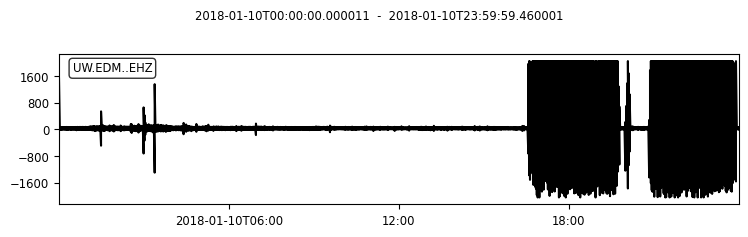

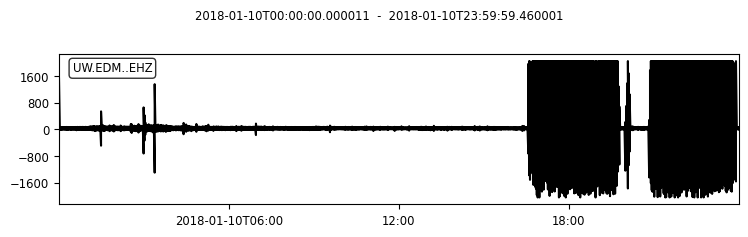

In [6]:
st_r.plot()

In [10]:
s1 = 'UW-EDM-EHZ' # station 1
s2 = 'UW-HSR-EHZ' # station 2
s3 = 'UW-SHW-EHZ' # station 3
s4 = 'CC-JRO-BHZ' # station 4
s_list = [s3,s4]

year = 2004
jday_range = np.arange(1,366+1)

day_netstacha = [tuple([str(i)]+[s]) for i in jday_range for s in s_list]
day_netstacha

[('1', 'UW-SHW-EHZ'),
 ('1', 'CC-JRO-BHZ'),
 ('2', 'UW-SHW-EHZ'),
 ('2', 'CC-JRO-BHZ'),
 ('3', 'UW-SHW-EHZ'),
 ('3', 'CC-JRO-BHZ'),
 ('4', 'UW-SHW-EHZ'),
 ('4', 'CC-JRO-BHZ'),
 ('5', 'UW-SHW-EHZ'),
 ('5', 'CC-JRO-BHZ'),
 ('6', 'UW-SHW-EHZ'),
 ('6', 'CC-JRO-BHZ'),
 ('7', 'UW-SHW-EHZ'),
 ('7', 'CC-JRO-BHZ'),
 ('8', 'UW-SHW-EHZ'),
 ('8', 'CC-JRO-BHZ'),
 ('9', 'UW-SHW-EHZ'),
 ('9', 'CC-JRO-BHZ'),
 ('10', 'UW-SHW-EHZ'),
 ('10', 'CC-JRO-BHZ'),
 ('11', 'UW-SHW-EHZ'),
 ('11', 'CC-JRO-BHZ'),
 ('12', 'UW-SHW-EHZ'),
 ('12', 'CC-JRO-BHZ'),
 ('13', 'UW-SHW-EHZ'),
 ('13', 'CC-JRO-BHZ'),
 ('14', 'UW-SHW-EHZ'),
 ('14', 'CC-JRO-BHZ'),
 ('15', 'UW-SHW-EHZ'),
 ('15', 'CC-JRO-BHZ'),
 ('16', 'UW-SHW-EHZ'),
 ('16', 'CC-JRO-BHZ'),
 ('17', 'UW-SHW-EHZ'),
 ('17', 'CC-JRO-BHZ'),
 ('18', 'UW-SHW-EHZ'),
 ('18', 'CC-JRO-BHZ'),
 ('19', 'UW-SHW-EHZ'),
 ('19', 'CC-JRO-BHZ'),
 ('20', 'UW-SHW-EHZ'),
 ('20', 'CC-JRO-BHZ'),
 ('21', 'UW-SHW-EHZ'),
 ('21', 'CC-JRO-BHZ'),
 ('22', 'UW-SHW-EHZ'),
 ('22', 'CC-JRO-BHZ'),
 ('23'